# Tutorial 2.3: Wave simulation (Example only)

In this tutorial you will learn how to simulate a wave elevation using the wave spectrum and assuming potential theory to describe the water kinematics. 

In this example we assume one wave direction (long-crested waves) only.

NOTE: you will require `wave_spectrum.py`

## Part 1: Calculate harmonic wave component parameters from a wave spectrum.
We start by defining the numerical values of all the parameters that will be needed:

- `spectrum_type` =1, ITTC-Modified Pierson_Moskowitz (p1=Hs,p2=T0)
- `spectrum_type` =2, JONSWAP (p1=Hs,p2=w0,p3=gamma)
- `spectrum_type` =3, Torsethaugen (p1=Hs,p2=W0)


- `hs`          - Significant wave heigh in sea state [m]
- `T0`          - Spectrum period at peak frequency in spectrum [s]
- `omega_peak`  - Peak frequency in spectrum [rad/s]
- `depth`       - Average water depth, for calculation of wave numbers [m]
- `nfreq`       - Number of frequency components [-]
- `omega_max`   - Cutoff frequency of spectrum = cutoff*omega_mean [rad]
- `rand_seed`   - Random number seed, applies to all random numbers (phase, rand frequency)

In [1]:
from module_imports.wave_spectrum_generator import wave_spectrum
import numpy as np
import matplotlib.pyplot as plt

# Parameters
spectrum_type = 3
hs = 1.0
T0 = 9
omega_peak = 2*np.pi/T0
depth = 20
nfreq = 20
omega_max = 3*omega_peak
rand_seed = 584
g = 9.81

With the given parameters we need to generate the following harmonic wave component parameters required for the time-simulations.

- `zeta_a`  - Vector of harmonic wave amplitudes
- `omega`   - Vector of harmonic wave frequencies
- `phase`   - Vector of harmonic wave phases (random)
- `wavenum` - Vector of harmonic wave numbers

In [2]:
# Frequency step
delta_omega = omega_max/nfreq

# Maximum simulation time (before the signal gets repeated)
max_time_sim = 2*np.pi/delta_omega

print("Max simulation time: "+str(max_time_sim))

# Frequency vector, starting at delta_omega
omega_vec = np.arange(delta_omega,omega_max + delta_omega,delta_omega)

Max simulation time: 60.0


Set random generator required to create the same set of random number based on the seed number. If this line is commented or unused, everytime we run the code we will have different random numbers. 

In [3]:
np.random.seed(rand_seed)

# Create evenly distributed random phases
phase = np.random.randn(1,nfreq)*2*np.pi

# Generate the spectral densities using the provided function
s_omega = wave_spectrum(spectrum_type, [hs, T0], omega_vec, 0)

Use: `S = wave_spectrum(SpecType, Par, W, PlotFlag)`

Input:

`SpecType`  - Spectrum type 

`Par`       - Spectrum parameters

`W`         - List of wave frequencies [rad/s]

`PlotFlag`  - `1` to plot the spectrum, `0` for no plot

Output:

`S`         - List of wave spectrum values [m^2 s]; evaluated at W[k]

We can plot the spectrum and the frequencies employed:

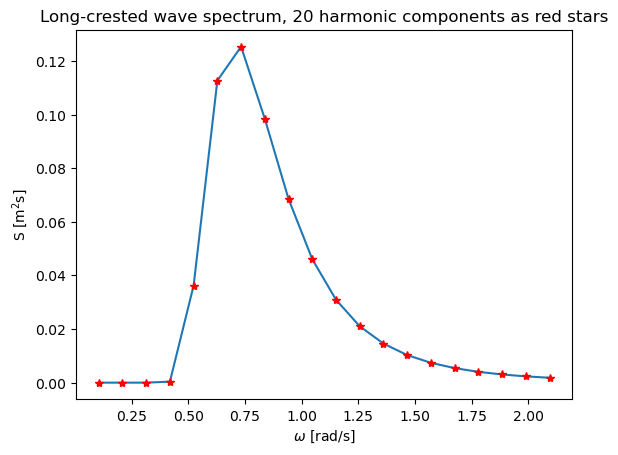

In [4]:
plt.figure()
plt.plot(omega_vec, s_omega)
plt.plot(omega_vec, s_omega, 'r*')
plt.xlabel("$\omega$ [rad/s]")
plt.ylabel("S [m$^2$s]")
plt.title("Long-crested wave spectrum, "+str(nfreq)+" harmonic components as red stars");

You can try using different number of harmonic components and check the simulation time.

Now we need to calculate the wave amplitude and wave number for every harmonic component.

In [5]:
from scipy.optimize import root_scalar
zeta_a = []
wavenum = []
for ii in np.arange(0, nfreq):
    # Calculate the wave amplitude.
    # The area under the spectrum represents 0.5*zeta_a^2
    # here we assume that this area is simply calculated by the S(w)*Deltaw.
    zeta_a.append(np.sqrt(2*s_omega[ii]*delta_omega))

    # Calculate the wave numbers using the dispersion relation
    # we are going to use the root_scaler function to solve the non-
    # linear equation
    wavenum_0 = omega_vec[ii]**2/g
    def func(k):
        return k*np.tanh(k*depth) - omega_vec[ii]**2/g
    sol = root_scalar(func, method='toms748', bracket=[wavenum_0, 1e10])
    wavenum.append(sol.root)
omega = omega_vec

Now we have defined all our required parameters!

## Part 2: Create time domain simulation of wave eleveation

List of time values for simulation
Note: depending on number of frequency components (`nfreq`), the time response will be repeated after $2\pi/$`delta_omega`

In [6]:
t = np.arange(0, 100.1, 0.1)

# Define position
x = 0.0

For each time step the wave elevation is obtained as the superpostiion of the different harmonic components. Please note that it can be done in a vectorial way for all frequencies and is not necessary to use a for loop.

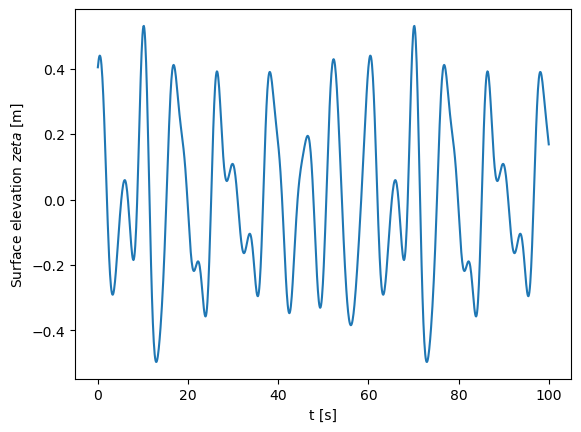

In [7]:
zeta = []
for i in np.arange(0, len(t)):
    zeta.append(np.sum(zeta_a*np.cos(omega*t[i] + phase - np.array(wavenum)*x)))

plt.figure()
plt.plot(t, zeta)
plt.xlabel("t [s]")
plt.ylabel("Surface elevation $zeta$ [m]");

-----------------------------------------------------------

**Problem**: Calculate the heave force and roll moment on a rectangular barge of dimensions 50x50 m. Plot the results in the time domain over an adequate time period.

*Hint*: You will need to make use of potential theory to calculate the pressure of the water underthe barge. At this point, this step should be straightforward since the wave parameters for the different harmonic components are already calculated in this tutorial. Note that the position where the pressure needs to be determined depends on to the motion of the structure.

------------------------------------------------------------
Some additional parameters:
- Barge dimensions: 50x50x4 m, in deep water
- Barge draft: 0.5 m in seawater $\rho$ = 1025 $kg/m^3$, assume uniform weight distribution
- Hydrodynamic added mass (in heave and roll) = 10% and damping = 1% of dry mass
- $H_s$ = 1.0 m, $T_0$ = 9 s, g = 9.81 N/kg (Same as before)

In [8]:
# Implement here ...
from scipy.integrate import solve_ivp

# Preparation work ----------------------------------------------------------------------------

# Primary parameterss
L_barge = 50     # m
B_barge = 50     # m
H_barge = 4      # m
T_barge = 0.5    # m
rho_w = 1025     # kg/m3
mass_add = 0.1   # -
damp_fac = 0.01  # -
H_s = 2          # m
T_s = 10         # s
g = 9.81         # N/kg
# Retake irregular waves from earlier waves
zeta_a = zeta_a
wavenum = wavenum
omega = omega

# Deducing additional parameters
W_barge = L_barge*B_barge*T_barge*rho_w # kg,   Barge weight
k_heave = L_barge*B_barge*rho_w*g       # N/m,  Heave stiffness = A*rho*g

nabla_s = B_barge*L_barge*T_barge     # Submerged volume, taken in neutral position
KB_s = T_barge/2
J = 1/12*W_barge*(B_barge**2 + T_barge**2)
BM_s = J/nabla_s
KG_s = H_barge/2
GM_s = (KB_s + BM_s - KG_s)
k_roll = rho_w*g*nabla_s*GM_s         # Nm/rad, Roll stiffness = rho*g*nabla_s*GM_s

# Pressures and forces for regular waves --------------------------------------------------------------------------------------
# Pressure determination 
def Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z,mu=0):
    return zeta_a_i*g/omega_i * np.exp(wavenum_i*z) * np.sin(wavenum_i*x*np.cos(mu)+wavenum_i*y*np.sin(mu)-omega_i*t)
def pressure(zeta_a_i, omega_i, wavenum_i, t,x,y,z,mu=0):
    fac = 0.0001 # For numerical derivatives
    dt = max(t*fac,0.001) # Max limits 0-entry errors in denominator
    dpdt = (Phi(zeta_a_i, omega_i, wavenum_i, t+dt,x,y,z)-Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z)) / dt
    dx = max(x*fac,0.001)
    u = (Phi(zeta_a_i, omega_i, wavenum_i, t,x+dx,y,z)-Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z)) / dx
    dy = max(y*fac,0.001)
    v = (Phi(zeta_a_i, omega_i, wavenum_i, t,x,y+dy,z)-Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z)) / dy
    dz = max(z*fac,0.001)
    w = (Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z+dz)-Phi(zeta_a_i, omega_i, wavenum_i, t,x,y,z)) / dz
    return rho_w*dpdt - 0.5*rho_w*(u**2+v**2+w**2) - rho_w*g*z
# Force function
def F_wave(zeta_a_i, omega_i, wavenum_i, t,z_centre, ang_pont, mu=0):    
    xlist = np.linspace(-L_barge/2, L_barge/2, n_points)
    plist = np.zeros(n_points)
    for i in range(len(xlist)):
        x = xlist[i]
        y = 1 # Not needed in practice, only for 3D
        z = z_centre+x*np.sin(ang_pont)
        plist[i] = -pressure(zeta_a_i, omega_i, wavenum_i, t,x,y,z) # Minus sign since push is on -z-direction face
    return np.trapz(plist,xlist)
# Moment function (around centre)
def M_wave(zeta_a_i, omega_i, wavenum_i, t,z_centre, ang_pont, mu=0):    
    xlist = np.linspace(-L_barge/2, L_barge/2, n_points)
    plist = np.zeros(n_points)
    for i in range(len(xlist)):
        x = xlist[i]
        y = 1 # Not needed in practice, only for 3D
        z = z_centre+x*np.sin(ang_pont)
        plist[i] = -pressure(zeta_a_i, omega_i, wavenum_i, t,x,y,z)*x # Minus sign since push is on -z-direction face
    return np.trapz(plist,xlist)

# Irregular superposition -------------------------------------------------------------------------------
def F_irreg(zeta_a, omega, wavenum, t, z_centre, ang_pont, mu=0):
    F_irregular = 0
    for i in range(len(zeta_a)):
        F_irregular += F_wave(zeta_a[i], omega[i], wavenum[i], t, z_centre, ang_pont)
    return F_irregular
def M_irreg(zeta_a, omega, wavenum, t, z_centre, ang_pont, mu=0):
    M_irregular = 0
    for i in range(len(zeta_a)):
        M_irregular += M_wave(zeta_a[i], omega[i], wavenum[i], t, z_centre, ang_pont)
    return M_irregular


# Result calculation ----------------------------------------------------------------------------------------
def fun_irreg(t, q):
    # print(t) # to follow progress
    u3 = q[0]
    u6 = q[1]
    v3 = q[2]
    v6 = q[3]
    a3 = (-k3*u3 - c3*v3 + F_irreg(zeta_a,omega,wavenum, t,u3,u6))/W_barge # From the equation of motion we can compute the acceleration
    a6 = (-k6*u6 - c6*v6 + M_irreg(zeta_a,omega,wavenum, t,u3,u6))/J       # From the equation of motion we can compute the acceleration
    return [v3, v6, a3, a6]
def RK4(tspan):
    return solve_ivp(fun=fun_irreg,t_span=[t_0,t_f],y0=q_0, t_eval=tspan)

In [9]:
t_0 =            0          # initial time [s]
t_f =            T0         # final time [s], Increase to see full force development (takes long)
q_0 = [0, 0, 0, 0]
m3 = W_barge*(1+mass_add)
c3 = W_barge*damp_fac
k3 = k_heave
m6 = J*(1+mass_add)
c6 = J*damp_fac
k6 = k_roll

n_points = 100
tspan = np.linspace(t_0,t_f, n_points)
out = RK4(tspan)

KeyboardInterrupt: 

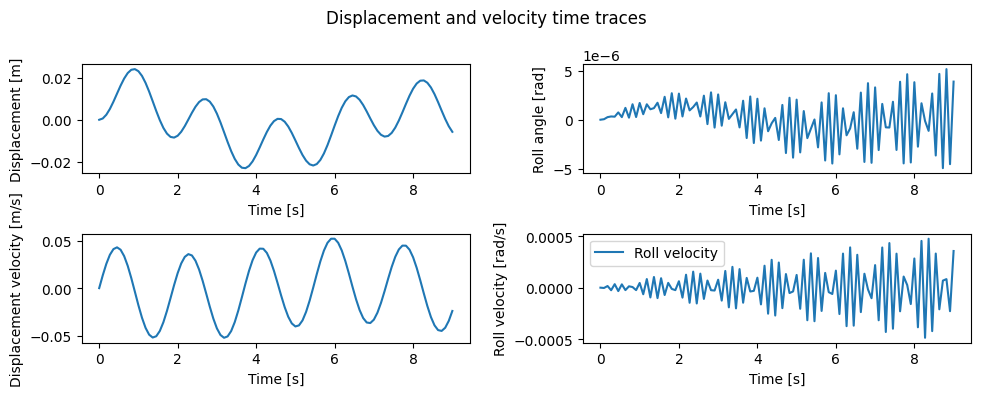

In [12]:
# PLOTS
plt.figure(figsize=(10,4))
plt.suptitle("Displacement and velocity time traces")
plt.subplot(221)
plt.plot(tspan, out.y[0], label=f"Heave displacement")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.subplot(222)
plt.plot(tspan, out.y[1], label=f"Roll displacement")
plt.xlabel("Time [s]")
plt.ylabel("Roll angle [rad]")
plt.subplot(223)
plt.plot(tspan, out.y[2], label=f"Heave velocity")
plt.xlabel("Time [s]")
plt.ylabel("Displacement velocity [m/s]")
plt.subplot(224)
plt.plot(tspan, out.y[3], label=f"Roll velocity")
plt.xlabel("Time [s]")
plt.ylabel("Roll velocity [rad/s]")
plt.legend()
plt.tight_layout()

-----------------------------------------------------------------------------------------------------
[The solution can be found here.](w2_t3_sol.ipynb)